# Process and Plot the Duration of Historical Heat Waves and Cold Snaps by Balancing Authority

This notebook process the evolution of the hottest heat wave and the coldest cold snap for each historical year (1980-2019) in the TGW data. The analysis is currently done at the BA level but it could concievably be done by county or state.

In [1]:
# Start by importing the packages we need:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from datetime import timedelta


## Set the Directory Structure

In [11]:
# Identify the data input and output directories:
data_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/wrf_to_tell_data/'
data_output_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Analysis/Heat_Wave_Cold_Snap_Duration/'
image_output_dir =  '/Users/burl878/Documents/IMMM/Images/TELL/Analysis/Heat_Wave_Cold_Snap_Duration/Plots_for_Allison/'


## Process the Historical Daily Minimum and Maximum Temperature Time Series

In [27]:
# Define a function to process the daily maximum and minimum temperature time series:
def process_daily_min_max_time_series(data_input_dir: str, data_output_dir: str, ba_to_process: str, scenario: str, start_year: int, end_year: int):
    
    # Loop over the years from the start year to the end year:
    for year in range(start_year,end_year,1):
        # Create the filename for the given BA and year combination:
        filename = (data_input_dir + scenario + '/' + ba_to_process + '_WRF_Hourly_Mean_Meteorology_' + str(year) + '.csv')
    
        # Read in the .csv file:
        met_df = pd.read_csv(filename)
    
        # Set the time variable as an index:
        met_df.index = pd.to_datetime(met_df['Time_UTC'])
        
        # Convert the temperature from Kelvin to Fahrenheit:
        met_df['T2'] = (1.8 * (met_df['T2'] - 273)) + 32
    
        # Compute the daily minimum and maximum temperature using resampling:
        temp_df = met_df.resample('D')['T2'].agg(['min', 'max']).reset_index()
        
        # Rename the variables for consistency:
        temp_df.rename(columns={'Time_UTC': 'Day', 'min': 'T2_Min', 'max': 'T2_Max'}, inplace=True)
        
        # Add a column with the year values to be used in grouping:
        temp_df['Year'] = temp_df['Day'].dt.strftime('%Y')
        
        # Reorder some of the variables:
        temp_df = temp_df[['Year', 'Day', 'T2_Min', 'T2_Max']].copy()
        
        # Set the day value as a datetime variable:
        temp_df['Day'] = pd.to_datetime(temp_df['Day'])
        
        # Aggregate the output into a new dataframe:
        if year == start_year:
           full_df = temp_df
        else:
           full_df = pd.concat([full_df, temp_df])
    
    #Initiate a counter to store the results:
    counter = 0;
    output_df = pd.DataFrame()
    
    # Loop over the years from the start year to the end year:
    for year in range((start_year+1),(end_year-1),1):
        # Iterate the counter by one:
        counter = counter + 1
            
        # Subset the full dataframe to just the year being processed:
        year_df = full_df.loc[full_df['Year'] == str(year)].copy()
        
        # Find coldest day of the year:
        coldest_day = year_df['Day'].loc[year_df['T2_Min'].idxmin()]
        
        # Add the coldest data and coldest temperature to the output file:
        output_df.loc[counter, 'Year'] = str(year)
        output_df.loc[counter, 'Coldest_Day'] = (str(coldest_day)).split(' ')[0]
        output_df.loc[counter, 'Coldest_Temp_F'] = year_df['T2_Min'].min().round(2)
        
        # Subset the full dataframe to a 20-day window around the coldest date:
        coldest_subset_df = pd.DataFrame(full_df['T2_Min'].loc[(full_df['Day'] >= (pd.to_datetime(coldest_day) - timedelta(days = 14))) 
                                                             & (full_df['Day'] <= (pd.to_datetime(coldest_day) + timedelta(days = 14)))].reset_index(drop=True))
        
        # Rename the column to reflect the year:
        coldest_subset_df.rename(columns={'T2_Min': str(year)}, inplace=True)
        
        # Aggregate the output into a new dataframe:
        if year == (start_year+1):
           coldest_output_df = coldest_subset_df
        else:
           coldest_output_df = pd.concat([coldest_output_df, coldest_subset_df], axis=1)
    
        # Find hottest day of the year:
        hottest_day = year_df['Day'].loc[year_df['T2_Max'].idxmax()]
                      
        # Add the hottest day and hottest temperature to the output file:
        output_df.loc[counter, 'Hottest_Day'] = (str(hottest_day)).split(' ')[0]
        output_df.loc[counter, 'Hottest_Temp_F'] = year_df['T2_Max'].max().round(2)
        
        # Subset the full dataframe to a 20-day window around the hottest date:
        hottest_subset_df = pd.DataFrame(full_df['T2_Max'].loc[(full_df['Day'] >= (pd.to_datetime(hottest_day) - timedelta(days = 14))) 
                                                             & (full_df['Day'] <= (pd.to_datetime(hottest_day) + timedelta(days = 14)))].reset_index(drop=True))
        
        # Rename the column to reflect the year:
        hottest_subset_df.rename(columns={'T2_Max': str(year)}, inplace=True)
        
        # Aggregate the output into a new dataframe:
        if year == (start_year+1):
           hottest_output_df = hottest_subset_df
        else:
           hottest_output_df = pd.concat([hottest_output_df, hottest_subset_df], axis=1)
    
    # Write out the dataframe to a .csv file:
    # output_df.to_csv((os.path.join(data_output_dir + ba_to_process + '_Extreme_Days_1981_to_2018.csv')), sep=',', index=False)
    
    return coldest_output_df, hottest_output_df


In [28]:
coldest_output_df, hottest_output_df = process_daily_min_max_time_series(data_input_dir = data_input_dir, 
                                                                         data_output_dir = data_output_dir, 
                                                                         ba_to_process = 'CISO',
                                                                         scenario = 'rcp45cooler_ssp3',
                                                                         start_year = 2020,
                                                                         end_year = 2059)

coldest_output_df


,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,...,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057
0,47.408,37.094,49.424,45.104,46.904,50.522,45.572,51.008,42.710,49.532,...,49.640,49.190,45.428,49.064,54.176,35.474,47.390,41.684,43.412,55.760
1,48.956,43.106,48.146,40.766,46.418,51.314,48.866,51.332,38.300,50.072,...,43.664,51.242,50.432,45.680,47.786,36.374,45.500,46.328,45.554,49.298
2,50.198,46.418,50.540,44.654,45.464,52.700,46.796,47.318,38.390,50.018,...,36.194,51.962,53.906,47.210,35.582,38.714,47.480,39.128,41.000,46.652
3,49.064,44.744,48.992,46.400,41.738,51.854,41.846,41.504,40.064,49.010,...,42.044,53.492,49.784,48.488,41.306,40.964,49.334,36.446,45.356,49.370
4,53.366,41.900,50.576,48.560,40.100,53.726,38.984,43.088,40.946,46.076,...,37.742,45.752,47.678,39.326,47.750,40.154,51.818,36.986,50.612,49.532
5,53.564,41.450,52.034,47.966,39.506,50.774,39.668,43.070,38.660,40.064,...,36.104,46.040,51.188,41.720,48.308,40.532,54.500,39.812,45.554,51.062
6,49.316,43.898,51.620,46.580,39.470,46.904,36.086,41.270,41.612,36.842,...,35.060,48.758,46.166,42.854,44.618,42.764,54.554,43.412,42.008,53.168
7,41.684,43.916,50.702,49.910,40.478,47.894,38.732,39.938,47.336,39.074,...,38.786,47.948,44.870,36.662,43.088,39.308,51.332,45.554,37.868,51.350
8,39.056,46.238,51.278,47.642,42.764,45.338,40.172,41.504,46.922,35.978,...,36.968,45.392,46.760,38.210,46.130,45.950,44.150,41.000,35.150,49.586
9,41.612,45.986,51.800,45.212,39.020,41.558,42.998,41.630,42.674,36.662,...,41.324,43.196,45.644,37.526,47.354,47.876,39.398,45.356,35.600,46.544


In [19]:
# Define a function to annual minimum and maximum temperature time series:
def plot_daily_min_max_time_series(ba_to_plot: str, scenario: str, start_year: int, end_year: int, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Compute the coldest and hottest days matrix using the function created above:
    coldest_output_df, hottest_output_df = process_daily_min_max_time_series(data_input_dir = data_input_dir,
                                                                             data_output_dir = data_output_dir, 
                                                                             ba_to_process = ba_to_plot,
                                                                             scenario = scenario, 
                                                                             start_year = start_year,
                                                                             end_year = end_year)
    
    t_min_mean = coldest_output_df.dropna().values.mean().round(2)
    t_max_mean = hottest_output_df.dropna().values.mean().round(2)
     
    # Make the plot:
    plt.figure(figsize=(20, 14))
    plt.rcParams['font.size'] = 12
    
    plt.subplot(211)
    for year in range((start_year+1),(end_year-1),1):
        plt.plot(np.arange(-14.5, 14.5, 1, dtype=int), hottest_output_df[str(year)], color='r', linestyle='-', linewidth=0.35)
    plt.plot([-14, 14], [t_max_mean, t_max_mean], color='gray', linestyle='--', linewidth=4)
    plt.plot(np.arange(-14.5, 14.5, 1, dtype=int), hottest_output_df.mean(axis=1), color='k', linestyle='-', linewidth=5)
    plt.xlim([-14, 14])
    plt.xticks(np.arange(-14.5, 14.5, 1, dtype=int),['-14','-13','-12','-11','-10','-9','-8','-7','-6','-5','-4','-3','-2','-1','$t_{0}$','+1','+2','+3','+4','+5','+6','+7','+8','+9','+10','+11','+12','+13','+14'])
    plt.ylim([hottest_output_df.dropna().values.min()-2, hottest_output_df.dropna().values.max()+2])
    plt.grid(True)
    plt.xlabel('Days from the Hottest Temperature of the Year');
    plt.ylabel('Daily Maximum Temperature [$^\circ$F]')
    plt.title(('Heat Wave Evolution from ' + str(start_year) + '-' + str(end_year) + ' (' + scenario + '): ' + ba_to_plot))
    
    plt.subplot(212)
    for year in range((start_year+1),(end_year-1),1):
        plt.plot(np.arange(-14.5, 14.5, 1, dtype=int), coldest_output_df[str(year)], color='b', linestyle='-', linewidth=0.35)
    plt.plot([-14, 14], [t_min_mean, t_min_mean], color='gray', linestyle='--', linewidth=4)
    plt.plot(np.arange(-14.5, 14.5, 1, dtype=int), coldest_output_df.mean(axis=1), color='k', linestyle='-', linewidth=5)
    plt.xlim([-14, 14])
    plt.xticks(np.arange(-14.5, 14.5, 1, dtype=int),['-14','-13','-12','-11','-10','-9','-8','-7','-6','-5','-4','-3','-2','-1','$t_{0}$','+1','+2','+3','+4','+5','+6','+7','+8','+9','+10','+11','+12','+13','+14'])
    plt.ylim([coldest_output_df.dropna().values.min()-2, coldest_output_df.dropna().values.max()+2])
    plt.grid(True)
    plt.xlabel('Days from the Coldest Temperature of the Year');
    plt.ylabel('Daily Minimum Temperature [$^\circ$F]')
    plt.title(('Cold Snap Evolution from ' + str(start_year) + '-' + str(end_year) + ' (' + scenario + '): ' + ba_to_plot))
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = (ba_to_plot + '_Heat_Wave_Cold_Snap_' + str(start_year) + '_' + str(end_year) + '_' + scenario + '_.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')


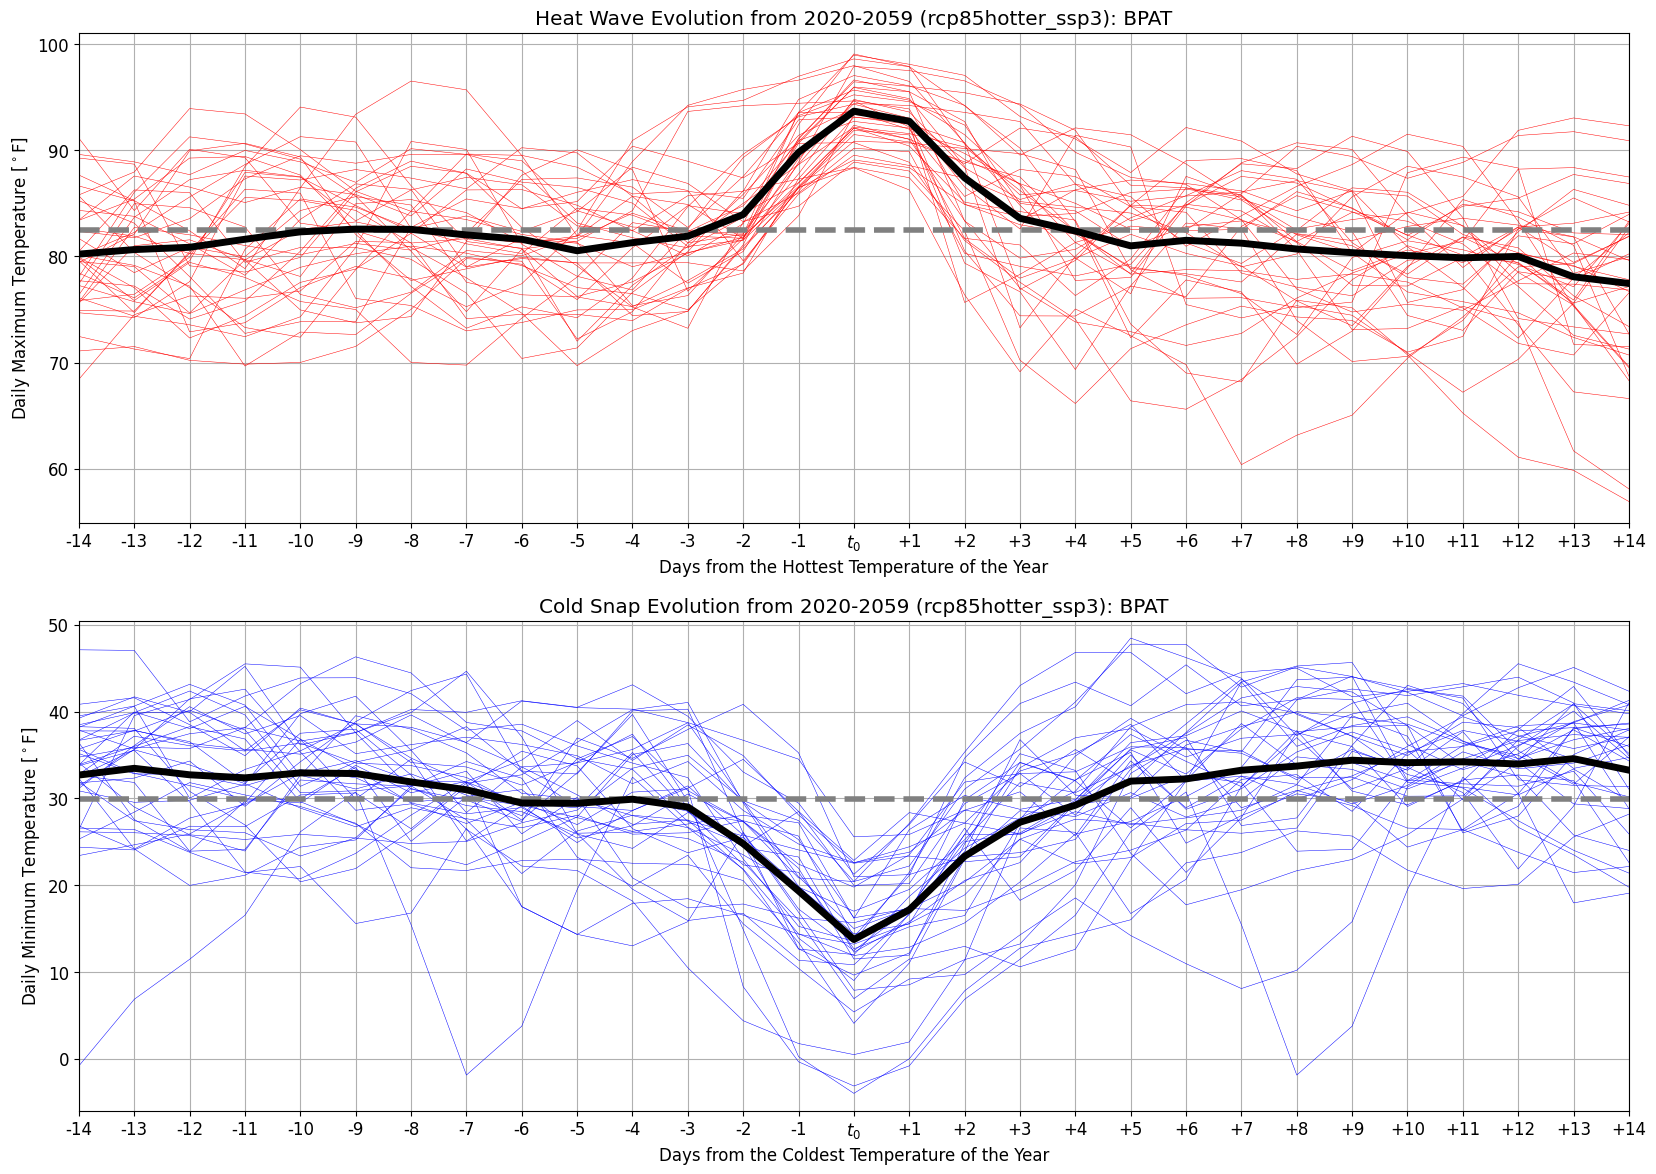

In [35]:
plot_daily_min_max_time_series(ba_to_plot = 'BPAT',
                               scenario = 'rcp85hotter_ssp3',
                               start_year = 2020,
                               end_year = 2059,
                               image_output_dir = image_output_dir, 
                               image_resolution = 300, 
                               save_images = True)
